In [32]:
import sys
curr_dir = '/user_data/vayzenbe/GitHub_Repos/hemispace'



#add curr_dir to path
sys.path.insert(1, curr_dir)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob as glob
from plotnine import *

import warnings
warnings.filterwarnings('ignore')

In [33]:
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
patient_subs = sub_info[sub_info['group'] == 'patient']

data_dir = f'{curr_dir}/behavior/space_feature'
results_dir = f'{curr_dir}/results'
fig_dir = f'{curr_dir}/figures'




sub_files = glob(f'{data_dir}/*.csv')


cols = ['condition', 'display','test_resp.corr', 'test_resp.rt']

In [34]:
summary_df = pd.DataFrame(columns = ['sub', 'exclude', 
                                     'overall_acc','spatial_parvo_acc', 'spatial_magno_acc', 'neither_parvo_acc','neither_magno_acc', 'feature_parvo_acc', 'feature_magno_acc',
                                     'overall_rt','spatial_parvo_rt', 'spatial_magno_rt', 'neither_parvo_rt','neither_magno_rt', 'feature_parvo_rt', 'feature_magno_rt'])

display_cond = ['M','P']
stim_cond = ['spatial','feature','neither']
data_types = ['test_resp.corr', 'test_resp.rt']

for file in sub_files:
    
    sub_data = pd.read_csv(file)

    curr_data = sub_data[cols]
    curr_data = curr_data.dropna()
    sub = sub_data['participant'][0]
    
    overall_acc = sub_data['test_resp.corr'].mean()
    overall_se = sub_data['test_resp.corr'].sem()
    
    if overall_acc - overall_se <= .33:
        exclude = 1
    else:
        exclude = 0

    curr_data['exclude'] = np.zeros((curr_data.shape[0],1))    

    #calc outlier limits
    max_val = curr_data['test_resp.rt'].mean() + (2.5* curr_data['test_resp.rt'].std())
    min_val = curr_data['test_resp.rt'].mean() - (2.5* curr_data['test_resp.rt'].std())
    
    
    #mark outliers
    curr_data['exclude'][curr_data['test_resp.rt'] >=max_val] = 1
    curr_data['exclude'][curr_data['test_resp.rt'] <min_val] = 1
    curr_data['exclude'][curr_data['test_resp.rt'] <.1] = 1
    
    #exclude outlier values
    curr_data = curr_data[curr_data['exclude'] == 0]
    
    
    '''
    calculate mean and RT for each cond
    '''
    #sort so its always in the same order
    grouped_data = curr_data.groupby(by=['condition','display']).mean().reset_index()
    grouped_data = grouped_data.sort_values(by=['condition', 'display'], ascending = False)
    
    acc_data = [curr_data['test_resp.corr'].mean()] + grouped_data['test_resp.corr'].tolist()
    
    #extract RT data where acc is 1
    curr_rt= curr_data[curr_data['test_resp.corr'] == 1]
    grouped_rt= curr_rt.groupby(by=['condition','display']).mean().reset_index()
    grouped_rt = grouped_data.sort_values(by=['condition', 'display'], ascending = False)
    
    rt_data = [curr_rt['test_resp.rt'].mean()] + grouped_rt['test_resp.rt'].tolist()
    
                
    final_data = [sub, exclude] + acc_data + rt_data
    final_data = pd.Series(final_data, index = summary_df.columns)
    
    summary_df = pd.concat([summary_df, final_data.to_frame().T], ignore_index=True)


#remove excluded subjects
summary_df = summary_df[summary_df['exclude'] == 0]


    

In [35]:
#add group column to sub_summary labeled patient or control
summary_df['group'] = summary_df['sub'].apply(lambda x: 'Patient' if x in patient_subs['code'].values else 'Control')

#if patient set intact_hemi to left or right from patient_subs, else set to intact
summary_df['intact_hemi'] = summary_df['sub'].apply(lambda x: patient_subs[patient_subs['code']==x]['intact_hemi'].values[0] if x in patient_subs['code'].values else 'Control')


#add sub_code for patients
summary_df['sub_code'] = summary_df['sub'].apply(lambda x: str(x) if x in patient_subs['code'].values else '')



In [37]:
#melt data for plotting
summary_melt = pd.melt(summary_df, id_vars=['sub', 'exclude', 'group', 'intact_hemi', 'sub_code'], value_vars=['spatial_parvo_acc', 'spatial_magno_acc', 'feature_parvo_acc', 'feature_magno_acc'], var_name='cond', value_name='acc')

#convert acc to float
summary_melt['acc'] = summary_melt['acc'].astype(float)

In [45]:
def create_acc_plot(data_mean, curr_cond):

    p = ggplot(data_mean, aes(x = 'cond', y = 'acc', fill = 'intact_hemi'))  + \
        geom_label(curr_cond, aes(x = 'cond', y = 'acc',fill = 'intact_hemi', label = 'sub_code'),  position = position_jitterdodge(dodge_width=.6, jitter_width = 0.1, random_state = 1),  size = 8) + \
        geom_linerange(aes(x = 'cond', ymin = 'acc-se', ymax = 'acc+se'), position = position_dodge(width=.6), size = 1) + \
        geom_point(position = position_dodge(width=.6), shape = 'o', size = 4,  stroke = 1)  + \
        xlab('Condition') + ylab('Accuracy') + ylim(0, 1) + \
        scale_fill_manual(values = ['#808080','#ee7183', '#7398af']) + \
        theme_classic() + geom_hline(yintercept = .33, linetype = 'dashed', color = 'black', size = 1) + \
        theme(text = element_text(color ='black'), 
            axis_text_x= element_text(angle = 30, size = 12),
            axis_text_y= element_text(size = 12),
            axis_title=element_text(size = 14),
            axis_line=element_line(), 
            panel_border=element_blank(),
            figure_size = (6, 6))+ \
            labs(fill='Group') #+ ggtitle(f'{cond}')
        
        

    print(p)

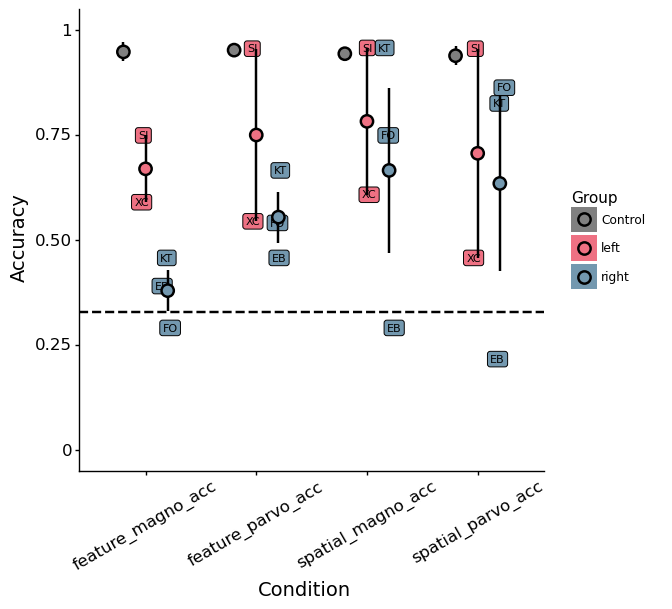

In [46]:
#extract complete condition
#curr_cond = sub_summary[sub_summary['cond']==cond]

#calcualte mean and sem for each duration
data_mean = summary_melt.groupby(['cond', 'intact_hemi']).mean().reset_index()
sem = summary_melt.groupby(['cond', 'intact_hemi']).sem().reset_index()
data_mean['se'] = sem['acc']


#plot
create_acc_plot(data_mean, summary_melt)

In [12]:
#calculate difference scores for magno and parvo space - feature
summary_df['parvo_diff'] = summary_df['spatial_parvo_acc'] - summary_df['feature_parvo_acc']
summary_df['magno_diff'] = summary_df['spatial_magno_acc'] - summary_df['feature_magno_acc']
